This notebook is rough (and inefficient!) process to take a set of votes predicted by the model, transform them into a set of country rankings for each year (if vote predictions were made for several years), and evaluate the correlation between the true country rankings and the rankings that came about from the predicted votes. 

This process is carried out independantly for all mcmc samples, across all chains; so the result is a distribution of spearman's coefficients for the predicted rankings.

In [76]:
import pandas as pd
import numpy as np
import json
import arviz as az
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('df_main.csv')
print(df.columns)
df.head()

Index(['year', 'Artist', 'from_country', 'to_country', 'points',
       'total_points', 'rank', 'from_code2', 'from_code3', 'to_code2',
       'to_code3', 'Official_languages', 'Language_sung', 'Contains_English',
       'Contains_NonEnglish', 'Contains_Multiple_Languages',
       'Number_of_Languages', 'Contains_Own_Language', 'gender',
       'migration_v2p', 'population_p', 'prop_emigrants_v2p', 'migration_p2v',
       'population_v', 'prop_emigrants_p2v', 'migration_pop_year',
       'comps_since_last_win'],
      dtype='object')


,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,Contains_Own_Language,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_since_last_win
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,True,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,True,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,True,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,True,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,True,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42


In [60]:
# evaluate predicted and true competition rankings for each competition year
def ranks_per_year(df_votes_single_year,rank_on):
    assert len(df_votes_single_year['year'].unique()) == 1, 'df must contain votes from a single competition year'
    total_votes = {}
    for _,row in df_votes_single_year.iterrows():
        total_votes[row['to_code2']] = total_votes.get(row['to_code2'], 0) + row[rank_on]
    ranks = sorted(total_votes.items(), key=lambda x:x[1], reverse=True )
    count = 1
    for i,(k,v) in enumerate(ranks):
        total_votes[k] = (i,v)
    return total_votes

In [36]:
# load output from fitted model
az_fit = az.from_json("model_output/model_3_voter_bias_vector_1000_samples_3_chains_1998-2018.json")

In [70]:
df_test = df.loc[ df['year'] > 2018 ]

In [72]:
def format_votes(x):
  if x == 10.:
    return 12.
  elif x == 9.:
    return 10.
  return x
df_test['y_pred_chain0_sample0'] = az_fit.predictions.y_pred[0][0]
df_test['points_pred_chain0_sample0'] = (df_test['y_pred_chain0_sample0'] - 1.).apply(format_votes)
score_options = df_test['points_pred_chain0_sample0'].unique().tolist()
score_options.sort()
print(score_options)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0]


/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3771/1265946961.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred_chain0_sample0'] = az_fit.predictions.y_pred[0][0]
/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3771/1265946961.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['points_pred_chain0_sample0'] = (df_test['y_pred_chain0_sample0'] - 1.).apply(format_votes)


In [61]:
pred_ranks = ranks_per_year(df_test.loc[df_test['year'] == 2021], rank_on='points_pred_chain0_sample0')


{'AZ': (9, 104.0), 'BE': (5, 128.0), 'BG': (0, 171.0), 'CY': (12, 89.0), 'FI': (22, 53.0), 'FR': (18, 75.0), 'DE': (11, 90.0), 'GR': (7, 123.0), 'IS': (14, 88.0), 'IL': (19, 73.0), 'IT': (3, 140.0), 'LT': (21, 66.0), 'MT': (17, 77.0), 'MD': (6, 127.0), 'NL': (8, 118.0), 'NO': (10, 97.0), 'PT': (25, 43.0), 'RU': (2, 150.0), 'SM': (16, 84.0), 'RS': (24, 49.0), 'ES': (23, 52.0), 'SE': (1, 158.0), 'CH': (13, 89.0), 'UA': (4, 140.0), 'GB': (20, 69.0), 'AL': (15, 87.0)}


In [62]:
true_ranks = ranks_per_year(df.loc[df['year'] == 2021], rank_on='points')


{'AZ': (20, 23), 'BE': (19, 24), 'BG': (10, 83), 'CY': (13, 49), 'FI': (5, 156), 'FR': (1, 279), 'DE': (23, 0), 'GR': (8, 99), 'IS': (3, 223), 'IL': (16, 38), 'IT': (0, 302), 'LT': (7, 117), 'MT': (6, 135), 'MD': (12, 69), 'NL': (22, 2), 'NO': (18, 29), 'PT': (11, 83), 'RU': (9, 99), 'SM': (21, 18), 'RS': (14, 46), 'ES': (24, 0), 'SE': (15, 45), 'CH': (2, 250), 'UA': (4, 203), 'GB': (25, 0), 'AL': (17, 35)}


In [75]:
y_pred = az_fit.predictions.y_pred.to_numpy()
coeffs = []
for chain in range(y_pred.shape[0]):
    for sample in range(y_pred.shape[1]):
        df_test[f'y_pred_chain{chain}_sample{sample}'] = y_pred[chain][sample]
        df_test[f'points_pred_chain{chain}_sample{sample}'] = (df_test[f'y_pred_chain{chain}_sample{sample}'] - 1.).apply(format_votes)

        for year in [2019,2021,2022]:
            pred_ranks = ranks_per_year(df_test.loc[df_test['year'] == year], rank_on=f'points_pred_chain{chain}_sample{sample}')
            true_ranks = ranks_per_year(df.loc[df['year'] == year], rank_on='points')
            truth = []
            preds = []
            for k,(rank,count) in true_ranks.items():
                truth.append(rank)
                preds.append(pred_ranks[k][0])
            coeffs.append(spearmanr(truth,preds)[0])

/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3771/2125456.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'y_pred_chain{chain}_sample{sample}'] = y_pred[chain][sample]
/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3771/2125456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'points_pred_chain{chain}_sample{sample}'] = (df_test[f'y_pred_chain{chain}_sample{sample}'] - 1.).apply(format_votes)
/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_3771/2

(array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   3.,   3.,   2.,   4.,
          4.,   5.,   8.,   9.,  12.,  14.,  14.,  22.,  24.,  20.,  32.,
         34.,  40.,  51.,  61.,  79.,  84.,  87.,  87., 111., 120., 117.,
        141., 159., 161., 174., 198., 174., 210., 213., 217., 195., 191.,
        199., 238., 192., 189., 234., 190., 216., 207., 214., 192., 205.,
        182., 203., 150., 203., 165., 169., 157., 156., 173., 148., 163.,
        175., 114., 135., 121., 120., 124., 115., 106., 108.,  98.,  85.,
         68.,  77.,  56.,  44.,  47.,  36.,  34.,  26.,  13.,  20.,  10.,
         10.,   9.,   5.,   3.,   5.,   5.,   0.,   1.,   1.,   0.,   0.,
          1.]),
 array([-0.41401709, -0.40190085, -0.38978462, -0.37766838, -0.36555214,
        -0.3534359 , -0.34131966, -0.32920342, -0.31708718, -0.30497094,
        -0.2928547 , -0.28073846, -0.26862222, -0.25650598, -0.24438974,
        -0.2322735 , -0.22015726, -0.20804103, -0.19592479, -0.18380855,
        -0.17169231, -0.15

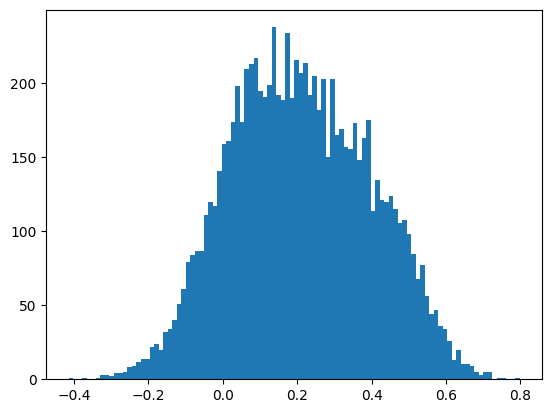

In [78]:
plt.hist(coeffs, bins=100)

In [ ]:
# a start on making the above more efficient
y_pred = az_fit.predictions.y_pred.to_numpy()
coeffs = []
true_ranks = {}
# dont calc this, already in dataframe under "rank"
# for year in [2019,2021,2022]:
#     ranks_dict = ranks_per_year(df.loc[df['year'] == year], rank_on='points')
#     truth = []
#     for k,(rank,count) in ranks_dict.items():
#         truth.append(rank)
#     true_ranks[f'{year}'] = truth
    

for chain in range(y_pred.shape[0]):
    for sample in range(y_pred.shape[1]):
        zero_idx_pred = y_pred[chain][sample] - 1.
        zero_idx_pred[zero_idx_pred == 10.] = 12.
        zero_idx_pred[zero_idx_pred == 9.] = 10.
        
        for year in [2019,2021,2022]:
            pred_ranks = ranks_per_year(df.loc[df['year'] == year], rank_on=f'points_pred_chain{chain}_sample{sample}')
            preds = []
            for k,(rank,count) in pred_ranks.items():
                preds.append(pred_ranks[k][0])
            coeffs.append(spearmanr(true_ranks[f'{year}'],preds)[0])